This google colab jupyter notebook simulates normalized 60 minute stock prices by sampling from the joint distribution of small encoded representations obtained by an autoencoder. The dependence structure of the joint distribution is estimated with a Gaussian copula. The autoencoder uses mostly 1d convolutional layers. After obtaining the new sample of small representations, these are fed into the decoder part of the autoencoder to yield unnormalized simulated stock prices.
The data on stock prices comes from twelvedata.com and contains minutely stock prices of 133 stocks in the sp500 from June 2020 to January 2023. The minutely volume data of these stocks is also used.

In [ ]:
%pip install scikit-fda

In [2]:
import pandas as pd
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import multivariate_normal

import skfda
from skfda.misc.hat_matrix import (
    KNeighborsHatMatrix,
    LocalLinearRegressionHatMatrix,
    NadarayaWatsonHatMatrix,
)
from skfda.misc.kernels import uniform
from skfda.preprocessing.smoothing import KernelSmoother
from skfda.preprocessing.smoothing.validation import SmoothingParameterSearch
from skfda import FDataGrid
import torch.nn.functional as F
import time
import torch.optim as optim


In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
!pwd
import pickle
from datetime import datetime
def restore_df(path):
    df = pd.read_csv(path)
    df = df.set_index(df['Unnamed: 0'])
    df.drop('Unnamed: 0', axis=1, inplace=True)
    return df
def save_obj(obj, name ):
     with open('drive/MyDrive/tradingbot/obj/'+ name + '.pkl', 'wb') as f:
         pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name ):
    with open('drive/MyDrive/tradingbot/obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
tic_ind = load_obj('tics_indices')

Mounted at /content/drive/
/content


In [4]:
# load adjusted close and volume
dfac = restore_df('drive/MyDrive/tradingbot/complete_230120/adj_complete.csv')
dfv = restore_df('drive/MyDrive/tradingbot/complete_230120/vol_complete.csv')
# use everythign except val indices as training
val_indices = range(35000, 65000)
tic_ind_tr = []
tic_ind_val = []
for i in range(len(tic_ind)):
  if tic_ind[i][1] not in val_indices:
    tic_ind_tr.append(tic_ind[i])
    continue
  if tic_ind[i][1] in val_indices:
    tic_ind_val.append(tic_ind[i])
print(len(tic_ind_tr)) # how many rows in training set
print(tic_ind_tr[1])
print(len(tic_ind_val)) # how many rows in validation set
print(tic_ind_val[1])
# tic_ind_tr give the tickers and indices of the training set. one observation will be 60 minutes 
# of (normalized) adjusted returns and volumes for a ticker.
# the 60 minutes will be from index-60:index.

433671
('MRNA', 83763)
66329
('SBUX', 46917)


In [5]:
dfac.head(-5) # prices of 133 stocks taken each minute (some adjusted closing price) from 2020-06-01 
# to 2023-01-20.
# dfv is the volume taken each minute for the same stocks and same timeframe.
# data taken from twelvedata.

,AAPL,AMZN,META,TSM,TSLA,V,JPM,NVDA,JNJ,WMT,...,COST,C,UL,AZN,BUD,PDD,GS,AMT,CAT,MMM
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2020-06-01 09:30:00,79.387500,2449.662475,223.939998,50.654000,172.170750,194.470000,97.662500,352.050005,147.734998,123.756450,...,308.092925,47.900400,54.22500,54.393750,47.76490,66.30250,196.521253,257.383793,119.216250,155.917498
2020-06-01 09:31:00,79.537915,2454.709960,225.270000,50.737500,173.060500,194.899998,97.792100,352.906507,147.798747,123.915500,...,308.525010,48.062500,54.28625,54.430800,47.80500,66.96500,196.627500,257.718760,118.734950,156.009923
2020-06-01 09:32:00,79.667500,2456.404968,225.000000,50.757500,173.086650,194.907500,97.781950,352.707493,147.987050,123.961650,...,308.759997,48.127500,54.28250,54.387500,47.75540,67.20750,196.720000,257.867500,118.258900,155.732497
2020-06-01 09:33:00,79.556235,2457.949950,225.152500,50.677500,172.674000,194.400000,97.627000,349.940000,148.063970,123.562300,...,308.254993,48.018750,54.23750,54.272500,47.67250,66.92000,196.674993,256.999910,118.140000,155.584997
2020-06-01 09:34:00,79.485675,2456.260010,225.515855,50.651250,172.661025,194.075775,97.714925,349.657492,148.070000,123.460000,...,307.835005,47.981250,54.17500,54.207500,47.60750,66.56625,196.610007,256.245010,118.221250,155.370230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-20 15:50:00,137.500002,97.167450,139.425005,90.771250,133.180003,223.737500,134.987492,178.017500,168.277000,140.435002,...,479.512502,50.931200,50.95125,69.116250,59.71875,92.95500,343.025000,220.451250,249.268753,120.171250
2023-01-20 15:51:00,137.566683,97.163750,139.399972,90.782500,133.180625,223.891240,135.009997,178.080798,168.279998,140.537508,...,479.855000,50.953750,50.96650,69.101250,59.70750,92.96250,342.840003,220.666253,249.435005,120.223750
2023-01-20 15:52:00,137.705008,97.251250,139.441250,90.811250,133.329950,224.050005,135.072500,178.284998,168.305005,140.572833,...,480.177498,50.985625,50.97625,69.125000,59.70500,92.99000,343.027503,220.902500,249.577497,120.312500


In [6]:
from tables import Array
# mean function which gives one if mean is zero (because volume can have mean of zero, if stock was 
# not traded over 60 minutes. in that case normalization can't divide by zero.)
def mean(array):
  mean = np.mean(array)
  if mean == 0:
    return 1
  else:
    return mean
def ksmooth(array, bw=2):
  smo = FDataGrid(
    grid_points=range(60),
    data_matrix=array,
  )
  smo1 = KernelSmoother(
      kernel_estimator=NadarayaWatsonHatMatrix(bandwidth=bw),
  ).fit_transform(smo)
  return smo1.data_matrix.reshape(1,60)

# get a list with the (training and validation) observations. normalize the adjusted closing prices 
# by subtracting the (60 minute) mean and dividing by the 60 minute mean.
# I don't divide by the standard deviation, because this would result in a standard deviation of 1 
# for all observations, which would lose too much information for the autoencoder.
# the volume data is smoothed with a nadaraya watson kernel with bandwith 2 minutes.
tr = []
for tic_ind in tic_ind_tr:
  ac = (dfac[tic_ind[0]][(tic_ind[1]-60):tic_ind[1]]).to_numpy()
  ac = (ac-np.mean(ac))/np.mean(ac)
  vol = (dfv[tic_ind[0]][(tic_ind[1]-60):tic_ind[1]]).to_numpy()
  vol = (vol-np.mean(vol))/mean(vol)
  tr.append(np.vstack((ac, ksmooth(vol))))
val = []
for tic_ind in tic_ind_val:
  ac = (dfac[tic_ind[0]][(tic_ind[1]-60):tic_ind[1]]).to_numpy()
  ac = (ac-np.mean(ac))/np.mean(ac)
  vol = (dfv[tic_ind[0]][(tic_ind[1]-60):tic_ind[1]]).to_numpy()
  vol = (vol-np.mean(vol))/mean(vol)
  val.append(np.vstack((ac, ksmooth(vol))))

In [7]:
# make the dataset object for the autoencoder
class acvol_data(Dataset):
  def __init__(self, train_or_val):
    xy = np.array(train_or_val)
    self.features = torch.from_numpy(xy)
    self.targets = torch.from_numpy(xy[:,0,:])
    self.n_samples = xy.shape[0]

  def __getitem__(self,index):
    return self.features[index], self.targets[index]

  def __len__(self):
    return self.n_samples

In [10]:
class Reshape(nn.Module):
  def __init__(self, *args):
    super().__init__()
    self.shape=args
  def forward(self, x):
    return torch.reshape(x, self.shape)

# this autoencoder uses 1d convolutional layers. 2 input channels are: 60 minute normalized prices 
# and 60 minute smoothed volume. encoded prices are of lenght 5.
# output of the model should be the original 50 minute normalized prices
class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
      nn.Conv1d(in_channels=2, out_channels=10, kernel_size = 5, stride=1, padding=2), #60
      nn.LeakyReLU(0.01),
      nn.Conv1d(in_channels=10, out_channels=20, kernel_size = 5, stride=2, padding=0), #28
      nn.LeakyReLU(0.01),
      nn.Conv1d(in_channels=20, out_channels=20, kernel_size = 3, stride=2, padding=0), #13
      nn.LeakyReLU(0.01),
      nn.Flatten(),
      nn.Linear(260, 5)
    )

    self.decoder = nn.Sequential(
      nn.Linear(5, 260),
      Reshape(-1, 20, 13),
      nn.ConvTranspose1d(in_channels=20, out_channels=20, kernel_size=3, 
                         stride=2, padding=0, output_padding=1), #28
      nn.LeakyReLU(0.01),
      nn.ConvTranspose1d(in_channels=20, out_channels=10, kernel_size=5, 
                         stride=2, padding=0, output_padding=1), #60
      nn.LeakyReLU(0.01),
      nn.ConvTranspose1d(in_channels=10, out_channels=1, kernel_size=5, 
                         stride=1, padding=2, output_padding=0),
      nn.LeakyReLU(0.01),
      nn.Linear(60,60),
      Reshape(-1, 60)
    )

  def forward(self, x, encoding_decoding="both"):
    if encoding_decoding == "both":
      x = self.encoder(x)
      x = self.decoder(x)
      return x
    if encoding_decoding == "encoding":
      x = self.encoder(x)
      return x
    if encoding_decoding == "decoding":
      x = self.decoder(x)
      return x

In [11]:
def train_autoencoder(num_epochs, model, optimizer, device, train_loader, val_loader, 
                      loss_fn=None, logging_interval=100, skip_epoch_stats=False, save_model=None):

  if loss_fn is None:
    loss_fn = F.mse_loss

  start_time = time.time()

  epoch_losses_train = []
  epoch_losses_val = []
  min_val_loss = float("inf")

  for epoch in range(num_epochs):

    model.train()

    batch_losses_train = []
    for batch_idx, (features, targets) in enumerate(train_loader):

      features = features.to(device, dtype=torch.float)
      targets = targets.to(device, dtype=torch.float)
      # Forward and Backward Prop
      output = model(features)
      loss = loss_fn(output, targets)
      optimizer.zero_grad()

      loss.backward()

      # Update model params
      optimizer.step()

      # Logging
      batch_losses_train.append(loss.item())
      if not batch_idx % logging_interval:
        print('Epoch: %03d/%03d | Batch: %04d/%04d | Loss: %.5f' % (epoch+1, num_epochs, 
                                                                    batch_idx, len(train_loader),
                                                                    loss.item()*1e6))

    if not skip_epoch_stats:
      model.eval()
      val_loss = []
      with torch.no_grad():
        for i, (features, targets) in enumerate(val_loader):
          features = features.to(device, dtype=torch.float)
          targets = targets.to(device, dtype=torch.float)
          output = model(features)
          loss = loss_fn(output, targets)
          val_loss.append(loss.item())

      epoch_losses_train.append(np.mean(np.array(batch_losses_train)))
      epoch_losses_val.append(np.mean(np.array(val_loss)))
      print('Elapsed Time: %.3f' % ((time.time()-start_time)/60))
      print('Epoch: %03d/%03d | Training Loss: %.5f | Val Loss: %.5f' % (epoch+1, 
                                                                         num_epochs, 
                                                                         np.mean(np.array(batch_losses_train))*1e6, np.mean(np.array(val_loss))*1e6))

    if save_model is not None:
      if np.mean(np.array(val_loss)) < min_val_loss:
        min_val_loss = np.mean(np.array(val_loss))
        torch.save(model.state_dict(), save_model)


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
# train the model
net = AutoEncoder()
tr_data = acvol_data(tr)
tr_dataloader = DataLoader(dataset=tr_data, batch_size=16, shuffle=True)
val_data = acvol_data(val)
val_dataloader = DataLoader(dataset=val_data, batch_size=16)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
net.to(device)
num_epochs = 5
train_autoencoder(num_epochs=num_epochs, model=net, optimizer=optimizer, device=device, 
                  train_loader=tr_dataloader, val_loader=val_dataloader, logging_interval=10000,
                  save_model = 'drive/MyDrive/tradingbot/autoencoder_adjclose/autoencoder_model.pth')

Epoch: 001/005 | Batch: 0000/27105 | Loss: 13904.50634
Epoch: 001/005 | Batch: 10000/27105 | Loss: 0.61555
Epoch: 001/005 | Batch: 20000/27105 | Loss: 0.69676
Elapsed Time: 1.892
Epoch: 001/005 | Training Loss: 3.71437 | Val Loss: 0.67362
Epoch: 002/005 | Batch: 0000/27105 | Loss: 0.45652
Epoch: 002/005 | Batch: 10000/27105 | Loss: 0.74056
Epoch: 002/005 | Batch: 20000/27105 | Loss: 0.57274
Elapsed Time: 3.560
Epoch: 002/005 | Training Loss: 0.67671 | Val Loss: 0.71919
Epoch: 003/005 | Batch: 0000/27105 | Loss: 0.71966
Epoch: 003/005 | Batch: 10000/27105 | Loss: 0.58416
Epoch: 003/005 | Batch: 20000/27105 | Loss: 0.60526
Elapsed Time: 5.214
Epoch: 003/005 | Training Loss: 0.65256 | Val Loss: 0.61236
Epoch: 004/005 | Batch: 0000/27105 | Loss: 1.10388
Epoch: 004/005 | Batch: 10000/27105 | Loss: 0.42996
Epoch: 004/005 | Batch: 20000/27105 | Loss: 0.67961
Elapsed Time: 6.916
Epoch: 004/005 | Training Loss: 0.66328 | Val Loss: 0.64714
Epoch: 005/005 | Batch: 0000/27105 | Loss: 0.86522
Epoch

In [16]:
# get the encoding of all validation observations
for batch_idx, (features, targets) in enumerate(val_dataloader):
  features = features.to(device, dtype=torch.float)
  if batch_idx == 0:
    val_encoding = net(features, encoding_decoding="encoding").detach().cpu().numpy()
  else:
    val_encoding = np.vstack((val_encoding, 
                              net(features, 
                                  encoding_decoding="encoding").detach().cpu().numpy()))
tics_val = []
inds_val = []
for i in range(len(tic_ind_val)):
  tics_val.append(tic_ind_val[i][0])
  inds_val.append(tic_ind_val[i][1])
val_encoding_df = pd.DataFrame(val_encoding, columns = ['ae1','ae2','ae3','ae4','ae5'])
val_encoding_df['tics'] = tics_val
val_encoding_df['inds'] = inds_val

In [17]:
val_encoding_df.head() # this is the encoding of the first 5 observations
# in the validation set.
#val_encoding_df.to_csv('drive/MyDrive/tradingbot/autoencoder_adjclose/val_encoding_3500065000.csv')

,ae1,ae2,ae3,ae4,ae5,tics,inds
0,0.115279,-0.058429,-0.038751,0.050005,0.140060,ADI,38866
1,0.121335,-0.075760,-0.030350,0.064118,0.189769,SBUX,46917
2,0.129521,-0.067507,-0.001304,0.052397,0.153418,MMC,54190
3,0.108646,-0.102108,-0.097563,0.061516,0.193405,SE,38412
4,0.144453,-0.079140,-0.030989,0.045142,0.130583,DUK,63290


In [18]:
# get the reconstruction of all observations in the validation dataset
for batch_idx, (features, targets) in enumerate(val_dataloader):
  features = features.to(device, dtype=torch.float)
  if batch_idx == 0:
    val_reconstructed = net(features).detach().cpu().numpy()

  else:
    val_reconstructed = np.vstack((val_reconstructed, net(features).detach().cpu().numpy()))


In [19]:
val_reconstructed_df = pd.DataFrame(val_reconstructed, columns = range(1,61))
val_reconstructed_df['tics'] = tics_val
val_reconstructed_df['inds'] = inds_val

In [20]:
# get the true observations in the validation set
val_true = []
for tic_ind in tic_ind_val:
  ac = (dfac[tic_ind[0]][(tic_ind[1]-60):tic_ind[1]]).to_numpy()
  ac = (ac-np.mean(ac))/np.mean(ac)
  val_true.append(ac.tolist())
val_true_df = pd.DataFrame(val_true)

In [21]:
# function to compare true stock prices vs reconstructed ones obtained from
# the autoencoder.
def plot_reconstruction(index, reconstructed_df, true_df):
  plt.plot(range(60), reconstructed_df.iloc[index, 0:60], label="reconstructed")
  plt.plot(range(60), true_df.iloc[index,], label="true")
  plt.legend()
  plt.title(reconstructed_df.iloc[index, 60])
  plt.show()

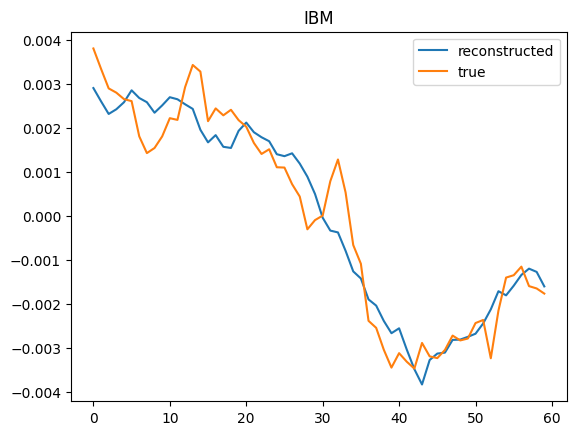

In [22]:
plot_reconstruction(5000, val_reconstructed_df, val_true_df)

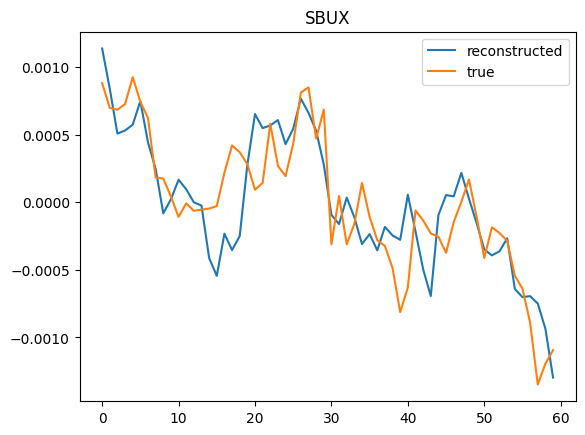

In [23]:
plot_reconstruction(1, val_reconstructed_df, val_true_df)

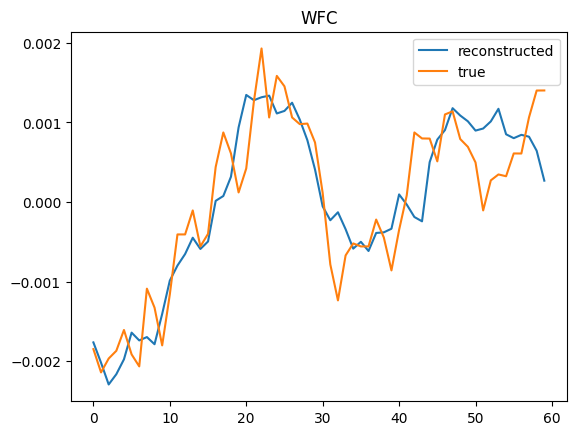

In [24]:
plot_reconstruction(10000, val_reconstructed_df, val_true_df)

The reconstructed prices are usually smoother than the original ones. But not in terms of standard deviation

<Axes: >

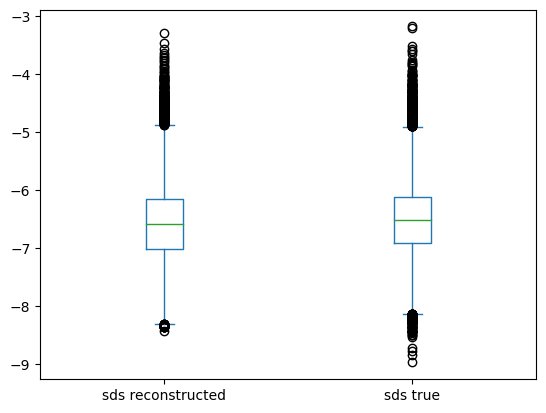

In [25]:
# standard deviations of constructed vs true. for better visibility: log(sd)
sds_reconstructed = val_reconstructed_df.iloc[:,0:60].apply(np.std, axis=1)
sds_true = val_true_df.apply(np.std, axis=1)
sds_df = pd.concat([np.log(sds_reconstructed), np.log(sds_true)], axis=1)
sds_df.columns = ["sds reconstructed", "sds true"]
sds_df.plot(kind="box")

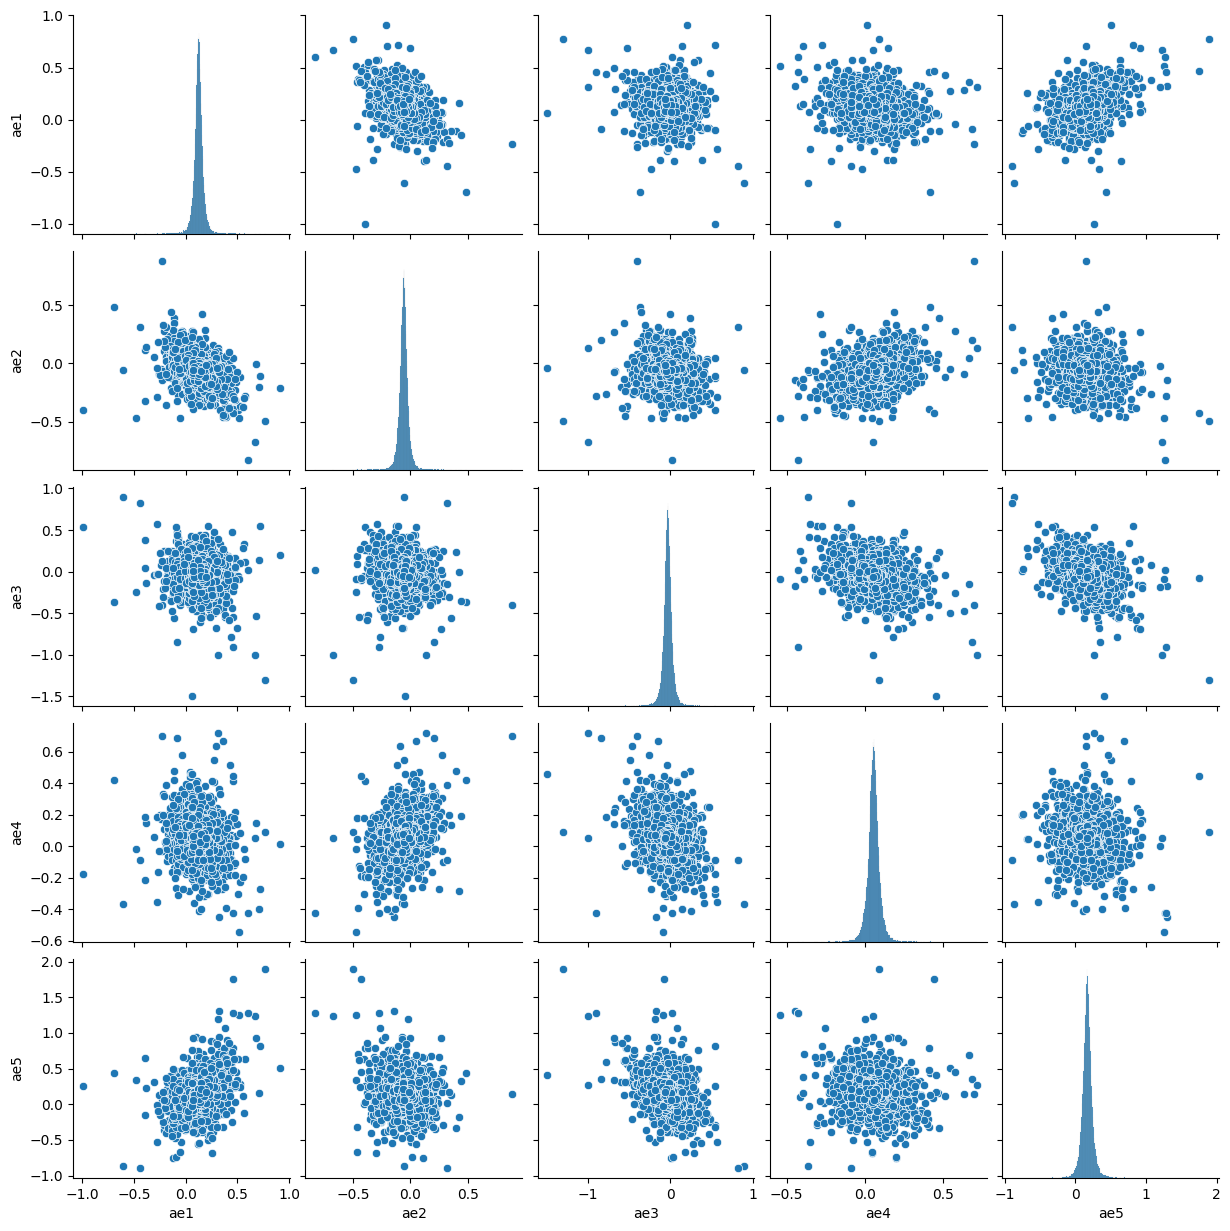

In [26]:
# We need to find out the joint distribution of encoding varibles, in order to simulate from them.
# 1 vs 1 dependencies of the encoding variables. Marginally, the distributions seem to be normal ones.
# For the 1 vs 1 dependencies a simple linear dependendy (correlation) seems to be enough.
# => Make gaussian copula.
sns.pairplot(val_encoding_df.iloc[:,0:5])

In [27]:
# For marginal distributions (assume gaussian marginals):
sds_encoding = val_encoding_df.iloc[:, 0:5].apply(np.std, axis=0)
means_encoding = val_encoding_df.iloc[:, 0:5].apply(np.mean, axis=0)
print(sds_encoding)
print(means_encoding)

ae1    0.046152
ae2    0.041025
ae3    0.058945
ae4    0.042450
ae5    0.079174
dtype: float32
ae1    0.125049
ae2   -0.058157
ae3   -0.032583
ae4    0.056762
ae5    0.170983
dtype: float32


In [28]:
# get probability integral transforms of marginals assuming they are guassian
# with parameters estimated one cell above.
encoding_pit_norm = val_encoding_df.iloc[:,0:5].apply({"ae1": lambda x: norm.cdf(x, loc=means_encoding[0], scale=sds_encoding[0]),
                                                  "ae2": lambda x: norm.cdf(x, loc=means_encoding[1], scale=sds_encoding[1]),
                                                  "ae3": lambda x: norm.cdf(x, loc=means_encoding[2], scale=sds_encoding[2]),
                                                  "ae4": lambda x: norm.cdf(x, loc=means_encoding[3], scale=sds_encoding[3]),
                                                  "ae5": lambda x: norm.cdf(x, loc=means_encoding[4], scale=sds_encoding[4])})



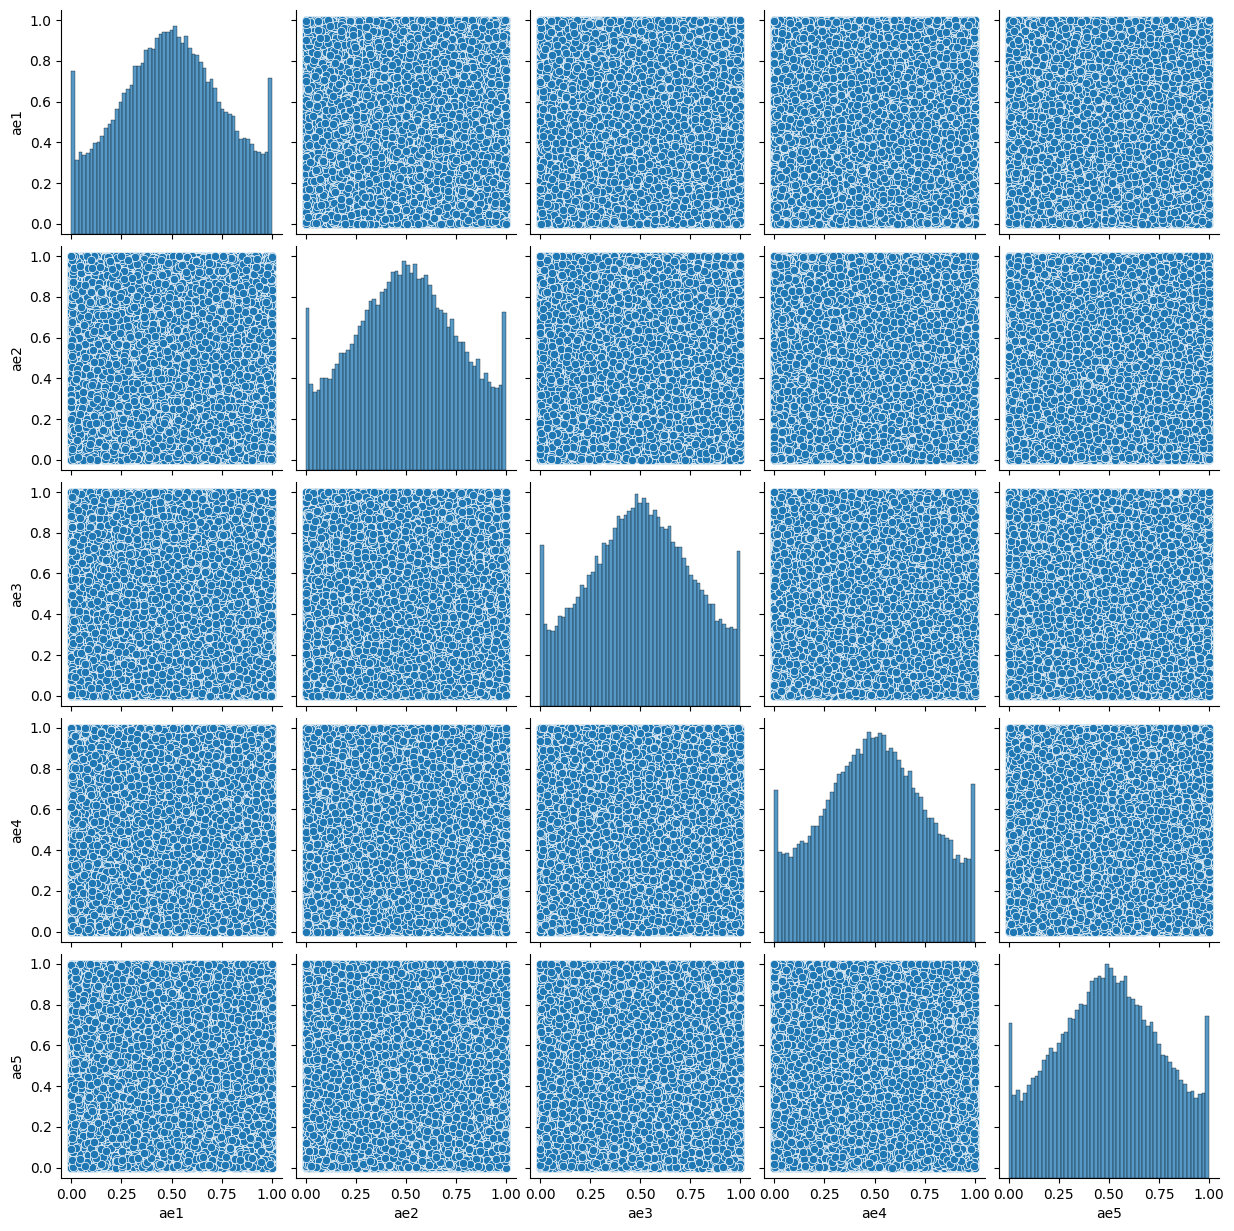

In [29]:
sns.pairplot(encoding_pit_norm)

The normal distributions are not good (we would expect the marginal distributions to be uniforms after applying the PIT of the true distributions). The original distributions have heavier tails. => use empirical distribution function.

In [30]:
from scipy.stats import ecdf

In [31]:
# get ecdf PITs of all the marginal distributions
def ecdf2(ae):
  ecdf1 = ecdf(ae)
  return ecdf1.cdf.evaluate(ae)
encoding_pit_ecdf = val_encoding_df.iloc[:,0:5].apply(ecdf2, axis=0, result_type="broadcast")

In [32]:
# now we have uniform marginals
print(encoding_pit_ecdf)
# from the uniform marginal distribution the sample correlation is an estimate
# of the gaussian copula covariance matrix.
copula_cov = encoding_pit_ecdf.corr()
print(copula_cov)

            ae1       ae2       ae3       ae4       ae5
0      0.380723  0.494475  0.435375  0.408404  0.294969
1      0.454371  0.278747  0.518974  0.598260  0.635016
2      0.557675  0.371874  0.764718  0.439777  0.376412
3      0.307558  0.097936  0.090594  0.564625  0.657842
4      0.722565  0.244328  0.512762  0.348671  0.245805
...         ...       ...       ...       ...       ...
66324  0.914427  0.526497  0.736993  0.772076  0.193400
66325  0.651450  0.549639  0.800283  0.154111  0.424324
66326  0.077749  0.468558  0.789820  0.557554  0.049285
66327  0.784378  0.438360  0.345550  0.716941  0.739646
66328  0.952329  0.895913  0.204149  0.404634  0.520180

[66329 rows x 5 columns]
          ae1       ae2       ae3       ae4       ae5
ae1  1.000000 -0.384608 -0.075155 -0.129754  0.353925
ae2 -0.384608  1.000000 -0.043492  0.324364 -0.127297
ae3 -0.075155 -0.043492  1.000000 -0.289933 -0.333727
ae4 -0.129754  0.324364 -0.289933  1.000000 -0.077817
ae5  0.353925 -0.127297 -0.33372

In [68]:
# simulate from the gaussian copula with mean 0 and covariance matrix equal 
# to the sample correlation matrix of the ecdf matrix.
copula_sam = multivariate_normal(mean = [0,0,0,0,0], cov = copula_cov).rvs(size=25); copula_sam

array([[-0.26496579,  1.14688816,  0.00603058,  0.68691788, -0.05811048],
       [-1.08209286,  0.76438683,  0.27934716, -1.37535921,  0.38550835],
       [ 0.50725303, -0.6093681 , -1.81228562, -0.00405817,  2.07576636],
       [ 0.75445231, -1.40216256, -0.43249555,  0.17483044,  0.0517358 ],
       [-0.62397682, -0.86012547, -0.76407157, -0.85492052,  0.57269236],
       [ 0.4883166 ,  0.94170452, -1.5973281 , -0.03185015,  0.04057153],
       [-1.33333077, -1.58047456,  1.87938349, -2.81798412, -0.46789166],
       [-0.58990596,  0.77437525,  1.11247275,  0.62797047,  0.86435196],
       [ 1.40521188, -0.45450293,  0.64464101, -0.443105  , -0.30270636],
       [ 0.7923861 ,  1.48312046, -0.03938979, -0.56414649,  0.17487403],
       [-0.37663368,  1.31086477,  0.38845982, -0.43665321,  0.18999365],
       [ 1.32001458, -0.98556924,  0.87516483,  1.25413086,  0.19104674],
       [ 0.98632677, -0.84783637, -0.08161248, -1.13004453,  0.44972187],
       [ 0.73230214, -0.67441798,  0.3

In [69]:
# in the gaussian copula each marginal distribution is a standard normal.
# get pit of copula_sam by appling the standard normal cdf. 
# now we have uniform marginals again.
pit_copula_sam = np.apply_along_axis(norm.cdf, axis=0, arr=copula_sam); pit_copula_sam

array([[0.39551791, 0.87428608, 0.50240584, 0.75393276, 0.47683031],
       [0.13960564, 0.77768162, 0.61001079, 0.08451005, 0.65006959],
       [0.69401136, 0.27114024, 0.03497104, 0.49838103, 0.98104222],
       [0.77471116, 0.08043335, 0.33269064, 0.56939357, 0.52063039],
       [0.2663214 , 0.19485994, 0.2224123 , 0.19629758, 0.71657349],
       [0.6873372 , 0.82682803, 0.05509629, 0.48729578, 0.51618126],
       [0.09121164, 0.05699911, 0.96990393, 0.00241631, 0.31993103],
       [0.27762685, 0.78064554, 0.86703253, 0.73498836, 0.80630271],
       [0.92002086, 0.32473344, 0.74042007, 0.32884489, 0.38105683],
       [0.78593221, 0.9309788 , 0.48428981, 0.28632722, 0.56941069],
       [0.35322293, 0.90504827, 0.65116211, 0.33118143, 0.57534295],
       [0.90658493, 0.16217227, 0.80925789, 0.89510278, 0.57575551],
       [0.83801361, 0.19826455, 0.46747744, 0.12922873, 0.6735445 ],
       [0.76800791, 0.25002281, 0.6227468 , 0.20642451, 0.69296032],
       [0.36591187, 0.7888138 , 0.

In [70]:
# function to get inverse ecdfs.
def inverse_ecdf(sorted_ae, q):
  l = len(sorted_ae)
  return (sorted_ae[int(l*q)])
pit_copula_sam_df = pd.DataFrame(pit_copula_sam)
pit_copula_sam_df.columns = ["ae1", "ae2", "ae3", "ae4", "ae5"]

In [71]:
# dataframe of the uniform marginal samples from before
pit_copula_sam_df

,ae1,ae2,ae3,ae4,ae5
0,0.395518,0.874286,0.502406,0.753933,0.476830
1,0.139606,0.777682,0.610011,0.084510,0.650070
2,0.694011,0.271140,0.034971,0.498381,0.981042
3,0.774711,0.080433,0.332691,0.569394,0.520630
4,0.266321,0.194860,0.222412,0.196298,0.716573
5,0.687337,0.826828,0.055096,0.487296,0.516181
6,0.091212,0.056999,0.969904,0.002416,0.319931
7,0.277627,0.780646,0.867033,0.734988,0.806303
8,0.920021,0.324733,0.740420,0.328845,0.381057
9,0.785932,0.930979,0.484290,0.286327,0.569411


In [72]:
# apply the inverse ecdf to the uniform marginals to get a sample of the
# joint embedding distribution.
sam_aes = pit_copula_sam_df.apply({"ae1": lambda x: inverse_ecdf(sorted(val_encoding_df["ae1"]), x),
                                                  "ae2": lambda x: inverse_ecdf(sorted(val_encoding_df["ae2"]), x),
                                                  "ae3": lambda x: inverse_ecdf(sorted(val_encoding_df["ae3"]), x),
                                                  "ae4": lambda x: inverse_ecdf(sorted(val_encoding_df["ae4"]), x),
                                                  "ae5": lambda x: inverse_ecdf(sorted(val_encoding_df["ae5"]), x)})

In [73]:
# sampled embeddings
sam_aes

,ae1,ae2,ae3,ae4,ae5
0,0.116559,-0.020174,-0.032006,0.078112,0.167646
1,0.086412,-0.034480,-0.020861,0.007099,0.192157
2,0.141552,-0.076474,-0.134208,0.056698,0.342334
3,0.150526,-0.107162,-0.050019,0.061890,0.173483
4,0.104410,-0.084863,-0.065359,0.029556,0.203490
5,0.140889,-0.028133,-0.115552,0.055901,0.172947
6,0.074210,-0.115589,0.073596,-0.121722,0.144367
7,0.105598,-0.034106,0.018703,0.076115,0.222309
8,0.179898,-0.071504,-0.004869,0.043481,0.154090
9,0.151993,-0.005247,-0.033835,0.039544,0.180381


In [74]:
# make the simulated sample to a dataset object to feed into the decoder
class newsample_data(Dataset):
  def __init__(self, sam):
    xy = np.array(sam)
    self.features = torch.from_numpy(xy)
    self.n_samples = xy.shape[0]

  def __getitem__(self,index):
    return self.features[index]

  def __len__(self):
    return self.n_samples

In [75]:
sam_data = newsample_data(sam_aes)

In [76]:
# check if it worked
print(len(sam_data))
extract_batch_idx = 0
for batch_idx, features in enumerate(sam_data):
      features = features.to(device, dtype=torch.float)
      if batch_idx == extract_batch_idx:
        break
print(features)

25
tensor([ 0.1166, -0.0202, -0.0320,  0.0781,  0.1676], device='cuda:0')


In [77]:
# make a dataloader from the dataset
sam_dataloader = DataLoader(dataset=sam_data)
extract_batch_idx = 0
for batch_idx, features in enumerate(sam_dataloader):
      features = features.to(device, dtype=torch.float)
      if batch_idx == extract_batch_idx:
        break
print(features)

tensor([[ 0.1166, -0.0202, -0.0320,  0.0781,  0.1676]], device='cuda:0')


In [78]:
# decode all the embeddings
for batch_idx, features in enumerate(sam_dataloader):
  features = features.to(device, dtype=torch.float)
  if batch_idx == 0:
    decoded_sam = net(features, encoding_decoding="decoding").detach().cpu().numpy()
  else:
    decoded_sam = np.vstack((decoded_sam, net(features, encoding_decoding="decoding").detach().cpu().numpy()))

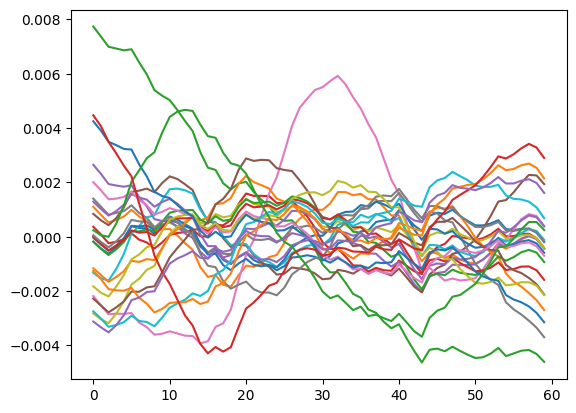

In [79]:
# plot the new normalized stock prices
def plot_newsample(newsample):
  for i in range(len(newsample)):
    plt.plot(range(60), newsample[i], label=f"sam{i}")
  plt.show()
plot_newsample(decoded_sam)

On the borders, all simulated stock prices have the exact same slopes. I think this is due to the 1d convolutional layers used. Also, at minute 42 for example a large portion of simulated stock prices have a change in the sign of their slopes, from negative to positive (something similar happens at other times). This is probably due to the strong decoding (60 values to 5) and the limited training time (only 5 epochs).